<h2>Preparing the environment ...</h2>

First, we need to import the required libraries ...

In [1]:
import pandas as pd
import numpy as np
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime as dt
plt.style.use('fivethirtyeight')
%matplotlib inline
import json

<h2>Importing the data</h2>

In order to analyze our taxi data, we first have to import it. The data has been stored in the Bluemix Object Storage, and we have to put in our own credentials here.

Please use the "Taxi-Simulator-Credentials" that you have created in chapter 2.4 and replace YOURUSERNAME, YOURDOMAINID and YOURPASSWORD in the code below with your credentials.

You also have to select one of the data files that have been written to the object storage. Please first go to the admin page of your object storage (hint: that is where you have obtained your credentials a few seconds ago, go to the "manage" section and click on the 'taxi' container. Choose any of the files there and just copy the file name. Replace YOUR_DATA_FILE in the code below with that file name.

In [2]:
from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_1aaf6e17ded243e984b8bfb7c8243484(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'YOURUSERNAME','domain': {'id': 'YOURDOMAINID'},
            'password': 'YOURPASSWORD'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face an error during data loading.
# Please read the documentation of 'pandas.read_json()' and 'pandas.io.json.json_normalize' to learn more about the possibilities to adjust the data loading.
# pandas documentation: http://pandas.pydata.org/pandas-docs/version/0.17.0/io.html#io-json-reader
# and http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.io.json.json_normalize.html

#df_data_2 = pd.read_json(get_object_storage_file_with_credentials_1aaf6e17ded243e984b8bfb7c8243484('molch', 'Taxi_data_3_taxis.json').read(), orient='values')
#df_data_2.head()

data_load = get_object_storage_file_with_credentials_1aaf6e17ded243e984b8bfb7c8243484('taxi', 'YOUR_DATA_FILE').read()



now that we have imported the data, lets have a look at it. Currently it is a single string object ...

In [3]:
#find the first line break
position = (data_load.find('\n'));
#and print the first five lines
print(data_load[:position*5+6]);

{"orgId":"ods86w","deviceType":"taxi","deviceId":"taxi001","eventType":"update","timestamp":"2017-06-28T08:18:33","sensorData":{"location":{"longitude":-96.79,"latitude":32.77},"velocity":16}}
{"orgId":"ods86w","deviceType":"taxi","deviceId":"taxi001","eventType":"update","timestamp":"2017-06-28T08:18:33","sensorData":{"location":{"longitude":-96.79,"latitude":32.77},"velocity":14}}
{"orgId":"ods86w","deviceType":"taxi","deviceId":"taxi001","eventType":"update","timestamp":"2017-06-28T08:18:33","sensorData":{"location":{"longitude":-94.2,"latitude":36.37},"velocity":18}}
{"orgId":"ods86w","deviceType":"taxi","deviceId":"taxi001","eventType":"update","timestamp":"2017-06-28T08:18:33","sensorData":{"location":{"longitude":-90.19,"latitude":38.62},"velocity":18}}
{"orgId":"ods86w","deviceType":"taxi","deviceId":"taxi001","eventType":"update","timestamp":"2017-06-28T08:18:33","sensorData":{"location":{"longitude":-98.49,"latitude":29.42},"velocity":19}}



... so lets get the data into a proper data frame to prepare it for analytics!

In [4]:
new_data = []
for line in data_load.split('\n'):
    try:
        new_data.append(json.loads(line))
    except:
        pass

Is the data now ready for analytics?

In [5]:
data = pd.DataFrame(new_data)
data.head()

,deviceId,deviceType,eventType,orgId,sensorData,timestamp
0,taxi001,taxi,update,ods86w,"{'velocity': 16, 'location': {'latitude': 32.7...",2017-06-28T08:18:33
1,taxi001,taxi,update,ods86w,"{'velocity': 14, 'location': {'latitude': 32.7...",2017-06-28T08:18:33
2,taxi001,taxi,update,ods86w,"{'velocity': 18, 'location': {'latitude': 36.3...",2017-06-28T08:18:33
3,taxi001,taxi,update,ods86w,"{'velocity': 18, 'location': {'latitude': 38.6...",2017-06-28T08:18:33
4,taxi001,taxi,update,ods86w,"{'velocity': 19, 'location': {'latitude': 29.4...",2017-06-28T08:18:33


Probably it is a good idea to store the sensor data in separate columns, since it will make it much easier to access it for analytics ...

In [6]:
sensordata = pd.DataFrame(line for line in data['sensorData'])
all_data = pd.merge(data, sensordata, left_index=True, right_index=True)
all_data.drop(['sensorData'],axis = 1, inplace=True)

all_data['velocity']= [int(x) for x in all_data['velocity']]
all_data['timestamp']= [pd.to_datetime(x) for x in all_data['timestamp']]
all_data['latitude'] = [float(x['latitude']) for x in all_data['location']]
all_data['longitude'] = [float(x['longitude']) for x in all_data['location']]
all_data.drop(['location'],axis = 1, inplace=True)
all_data.head()

,deviceId,deviceType,eventType,orgId,timestamp,velocity,latitude,longitude
0,taxi001,taxi,update,ods86w,2017-06-28 08:18:33,16,32.77,-96.79
1,taxi001,taxi,update,ods86w,2017-06-28 08:18:33,14,32.77,-96.79
2,taxi001,taxi,update,ods86w,2017-06-28 08:18:33,18,36.37,-94.20
3,taxi001,taxi,update,ods86w,2017-06-28 08:18:33,18,38.62,-90.19
4,taxi001,taxi,update,ods86w,2017-06-28 08:18:33,19,29.42,-98.49


Generate some additional meta data for visualisation ... the taxi dimension

In [7]:
taxis = list(set(data['deviceId']))
taxis


['taxi001', 'taxi003', 'taxi002']

A very simple way to visualize data interactively is Pixiedust. First we have to install it into our environment (you only have to do this th first time you want to use it, we use the upgrade option just in case an older version is already installed). Please convert this step to a comment using the '#' at the beginning of the line after successfully executing it.

In [8]:
#!pip install --user pixiedust --upgrade

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages
Requirement already up-to-date: astunparse in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: jupyter-kernel-gateway in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib

Requirement already up-to-date: setuptools>=18.5 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from ipython>=4.0.0->ipykernel->notebook<6.0,>=5.0.0->jupyter-kernel-gateway->pixiedust)
Requirement already up-to-date: pickleshare in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from ipython>=4.0.0->ipykernel->notebook<6.0,>=5.0.0->jupyter-kernel-gateway->pixiedust)
Requirement already up-to-date: pexpect; sys_platform != "win32" in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from ipython>=4.0.0->ipykernel->notebook<6.0,>=5.0.0->jupyter-kernel-gateway->pixiedust)
Requirement already up-to-date: prompt-toolkit<2.0.0,>=1.0.4 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s6af-1bb91d90e0104e-6d07e6a0504e/.local/lib/python3.5/site-packages (from ipython>=4.0.0->ipykernel->notebook<6

... now we can use it :-)
Please play a bit with it and try to create a chart. If you need help, please use the help section of the action bar 
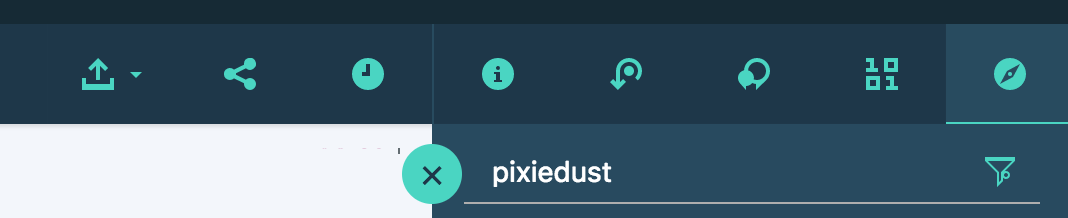

In [9]:
import pixiedust;
display(all_data);

Now lets create a chart based on matplotlib.pyplot ...

In [11]:
minutes = mdates.MinuteLocator()
minutesFmt = mdates.DateFormatter('%H:%M')

fig, ax = plt.subplots()
i = 0
alpha = 1.0
colors=['red','orange','blue', 'green', 'black']
colcount = len(colors)
for taxi in taxis:
    vals = all_data[all_data['deviceId']==taxi]['velocity']
    dates = all_data[all_data['deviceId']==taxi]['timestamp']
    k = i%colcount
    ax.plot_date(dates,vals, 'r-', color=colors[k], label=str(taxi), alpha=alpha) #k
    i+=1
    if len(taxis)>5:
        alpha-=0.3
    else:
        alpha-=0.4 ##0.3 better than 0.4 for >5 taxis
    
fig.set_size_inches((14,10))
fig.set_dpi(800)
ax.legend(labels=taxis,loc=2,columnspacing=1.0,
          fancybox=False,fontsize ='xx-large',frameon =True)
ax.set_title('Taxi velocity data', fontsize=30)
ax.set_ylabel('velocity')
ax.set_xlabel('Time')
ax.grid(True)
fig.autofmt_xdate()
ax.xaxis.set_major_locator(minutes)
ax.xaxis.set_major_formatter(minutesFmt)

plt.savefig('Graph')